# <span style="font-family: Arial, sans-serif; color:#97f788">xbooster</span>
## <span style="font-family: Arial, sans-serif; color:navyblue">Interpretability</span>

In this notebook we cover the main functionality of `xbooster` package on interpretability.

We will use a credit dataset to visualize the main interpretability features for `max_depth=1` and `max_depth>1` models.

1. Global interpretability
2. Local interpretability

<span style="font-family: Arial, sans-serif; color:navyblue">Repo: <a href="https://github.com/xRiskLab/xBooster" title="GitHub link">https://github.com/xRiskLab/xBooster</a></span>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Fetch blended credit data
dataset = pd.read_parquet("data/credit_data.parquet")

features = [
    "external_risk_estimate",
    "revolving_utilization_of_unsecured_lines",
    "account_never_delinq_percent",
    "net_fraction_revolving_burden",
    "num_total_cc_accounts",
    "average_months_in_file",
]

target = "is_bad"

X, y = dataset[features], dataset[target]

ix_train, ix_test = train_test_split(X.index, stratify=y, test_size=0.3, random_state=62)

### <span style="font-family: Arial, sans-serif; color: navyblue; font-size: 25px;">Global explanations</span>

#### `max_depth=1` trees

In [2]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

best_params = dict(
    n_estimators=100,
    learning_rate=0.55,
    max_depth=1,
    min_child_weight=10,
    grow_policy="lossguide",
    early_stopping_rounds=5,
)

# Create an XGBoost model
xgb_model = xgb.XGBClassifier(**best_params, random_state=62)
evalset = [
    (X.loc[ix_train], y.loc[ix_train]),
    (X.loc[ix_test], y.loc[ix_test]),
]

# Fit the XGBoost model
xgb_model.fit(
    X.loc[ix_train],
    y.loc[ix_train],
    eval_set=evalset,
    verbose=False,
)

# Make predictions using the model
predictions_trn = xgb_model.predict_proba(X.loc[ix_train])[:, 1]
predictions_tst = xgb_model.predict_proba(X.loc[ix_test])[:, 1]

# Calculate the Gini score
gini_trn = roc_auc_score(y.loc[ix_train], predictions_trn) * 2 - 1  # type: ignore
gini_tst = roc_auc_score(y.loc[ix_test], predictions_tst) * 2 - 1  # type: ignore

print(f"Train Gini score: {gini_trn:.2%}\nTest Gini score: {gini_tst:.2%}")

Train Gini score: 89.84%
Test Gini score: 89.11%


In [3]:
# Import necessary modules
from xbooster.constructor import XGBScorecardConstructor

# Set up the scorecard constructor
scorecard_constructor = XGBScorecardConstructor(xgb_model, X.loc[ix_train], y.loc[ix_train])

# Construct the scorecard
xgb_scorecard = scorecard_constructor.construct_scorecard()

xgb_scorecard_with_points = scorecard_constructor.create_points(
    pdo=50, target_points=600, target_odds=50
)

# Make predictions using the scorecard
credit_scores = scorecard_constructor.predict_score(X.loc[ix_test])
gini = roc_auc_score(y.loc[ix_test], -credit_scores) * 2 - 1  # type: ignore

print(f"Test Gini score: {gini:.2%}")

Test Gini score: 89.09%


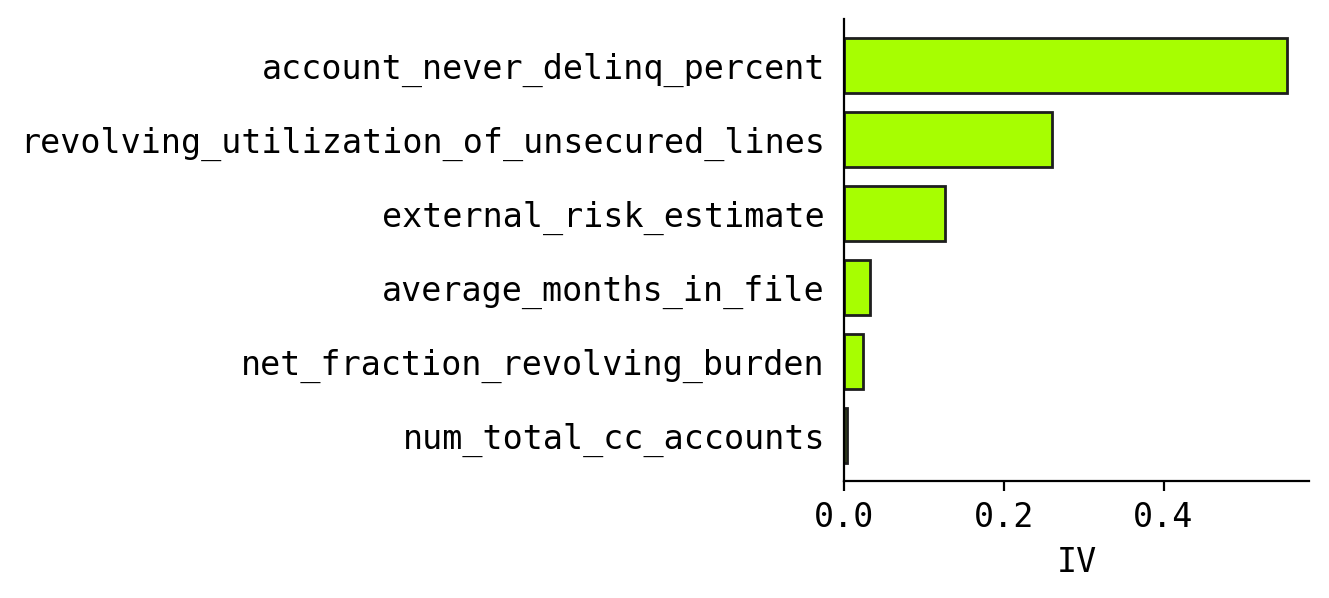

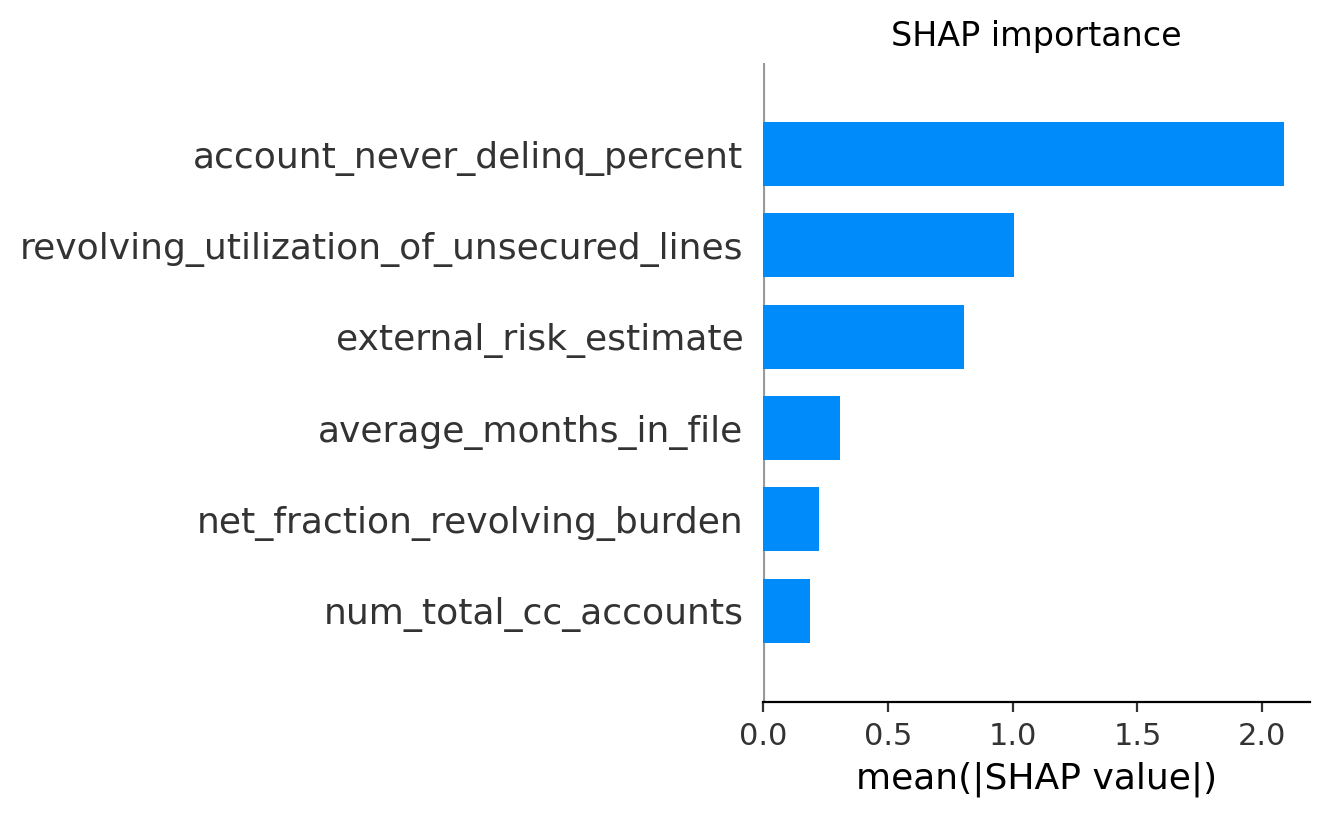

In [4]:
import shap
from matplotlib import pyplot as plt
from xbooster import explainer

%config InlineBackend.figure_format = 'retina'

shap.initjs()

# Calculate importance with IV
explainer.plot_importance(
    scorecard_constructor,
    metric="IV",
    normalize=True,
    color="#a7fe01",
    edgecolor="#1e1e1e",
    figsize=(3, 3),
    dpi=100,
    # title='Global importance (IV)',
)

# Calculate SHAP values
shap_values = xgb_model.get_booster().predict(xgb.DMatrix(X.loc[ix_train]), pred_contribs=True)

fig = plt.figure(dpi=100)
shap.summary_plot(
    shap_values[:, :-1],
    feature_names=X.columns,
    plot_type="bar",
    show=False,
)
plt.title("SHAP importance")
plt.xlabel("mean(|SHAP value|)")
plt.gcf().set_size_inches(5.5, 4)
plt.show()

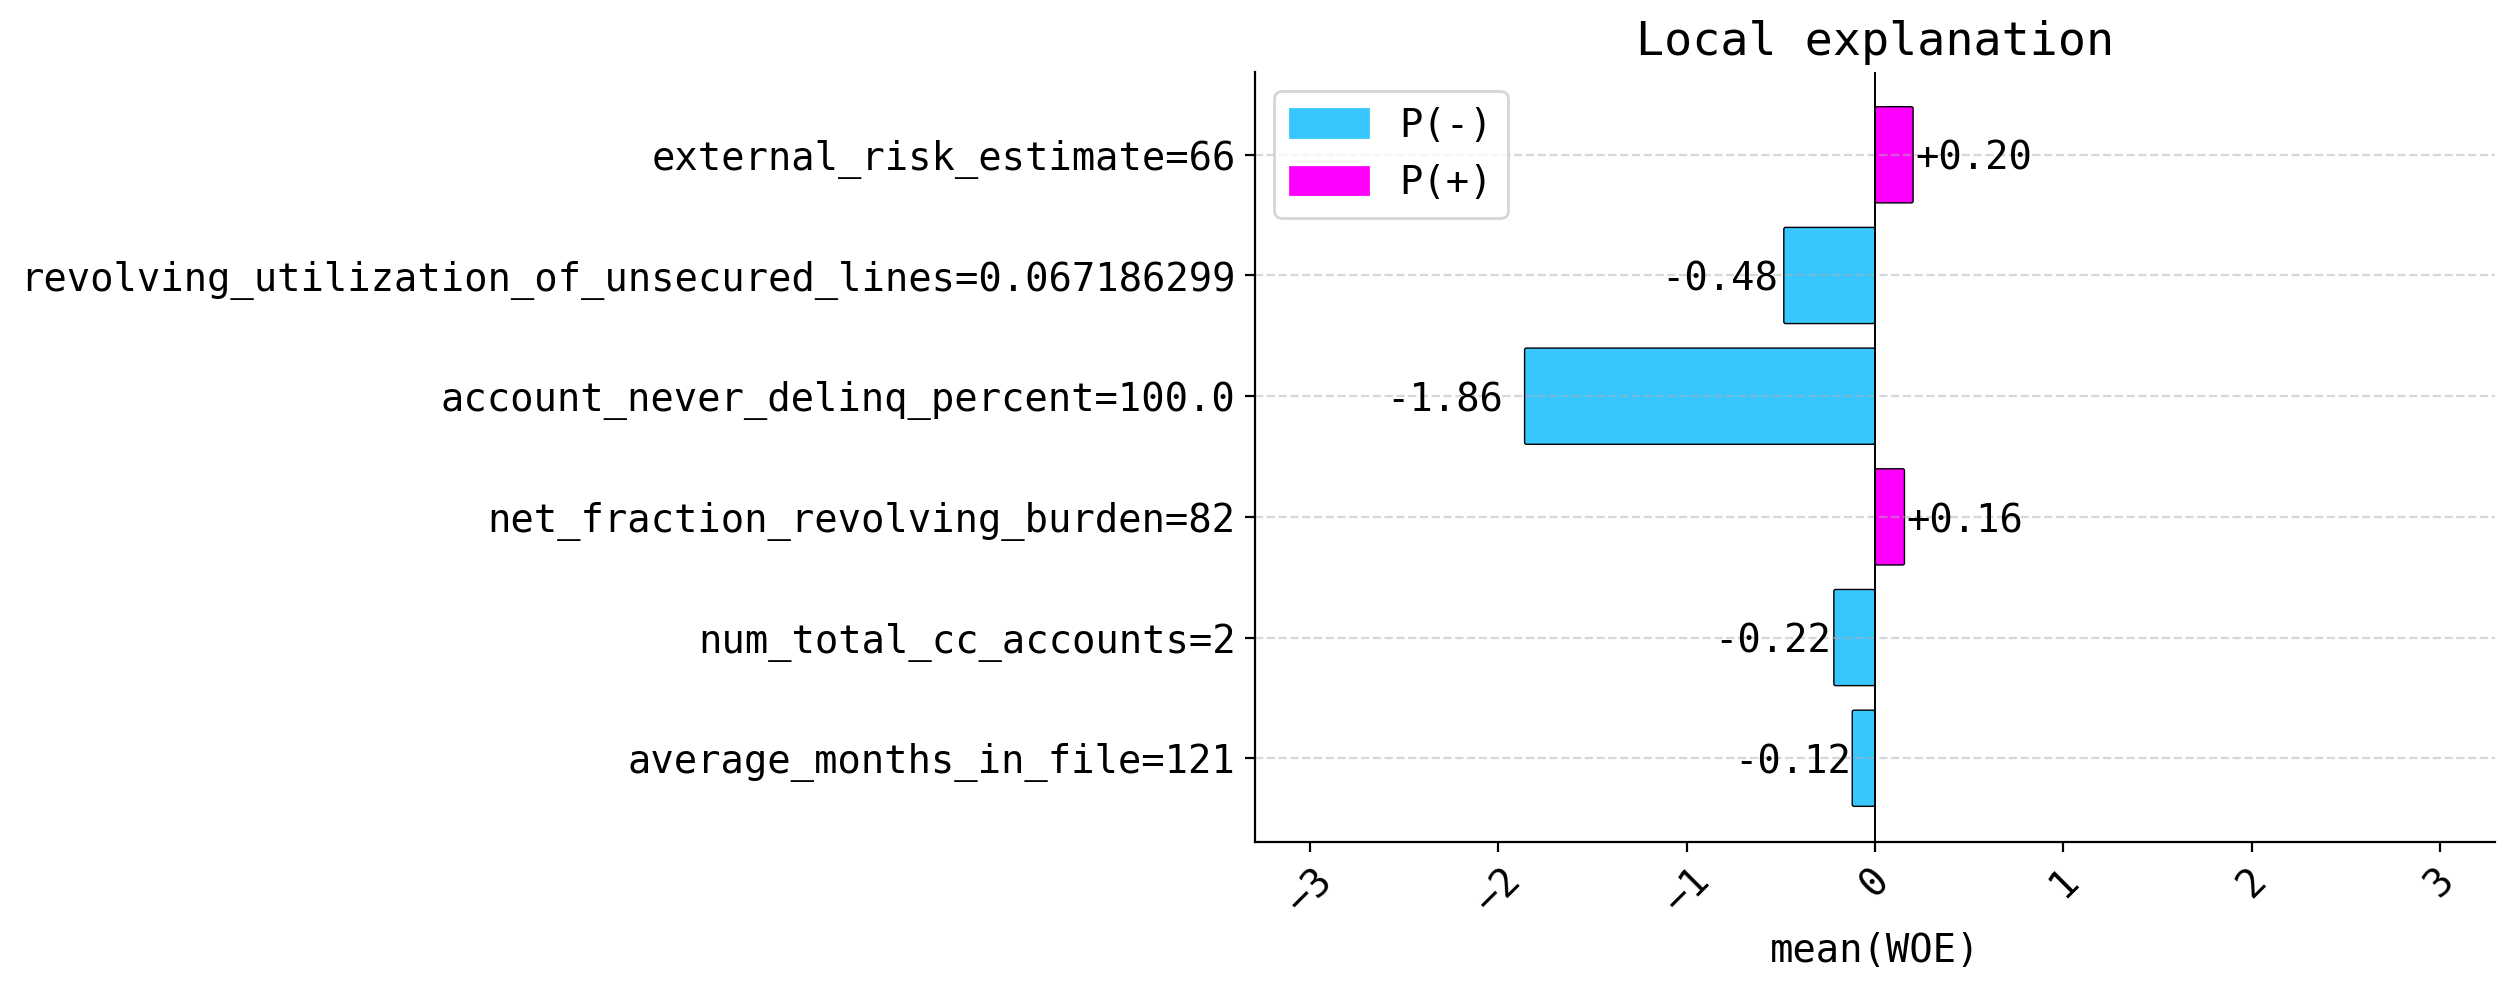

In [12]:
from xbooster import explainer

# %config InlineBackend.figure_format = 'retina'
sample_idx = 2
explainer.plot_local_importance(
    scorecard_constructor,
    X.loc[ix_test][sample_idx : sample_idx + 1],
    figsize=(8, 5),
    fontsize=14,
    dpi=100,
)

#### <span style="font-family: Arial, sans-serif; color: navyblue; font-size: 25px;">`max_depth > 1` trees</span>

In [9]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

best_params = dict(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=15,
    grow_policy="lossguide",
    early_stopping_rounds=5,
)

# Create an XGBoost model
xgb_model = xgb.XGBClassifier(**best_params, random_state=62)
evalset = [
    (X.loc[ix_train], y.loc[ix_train]),
    (X.loc[ix_test], y.loc[ix_test]),
]

# Fit the XGBoost model
xgb_model.fit(
    X.loc[ix_train],
    y.loc[ix_train],
    eval_set=evalset,
    verbose=False,
)

# Make predictions using the model
predictions_trn = xgb_model.predict_proba(X.loc[ix_train])[:, 1]
predictions_tst = xgb_model.predict_proba(X.loc[ix_test])[:, 1]

# Calculate the Gini score
gini_trn = roc_auc_score(y.loc[ix_train], predictions_trn) * 2 - 1  # type: ignore
gini_tst = roc_auc_score(y.loc[ix_test], predictions_tst) * 2 - 1  # type: ignore

print(f"Train Gini score: {gini_trn:.2%}\nTest Gini score: {gini_tst:.2%}")

Train Gini score: 91.20%
Test Gini score: 89.17%


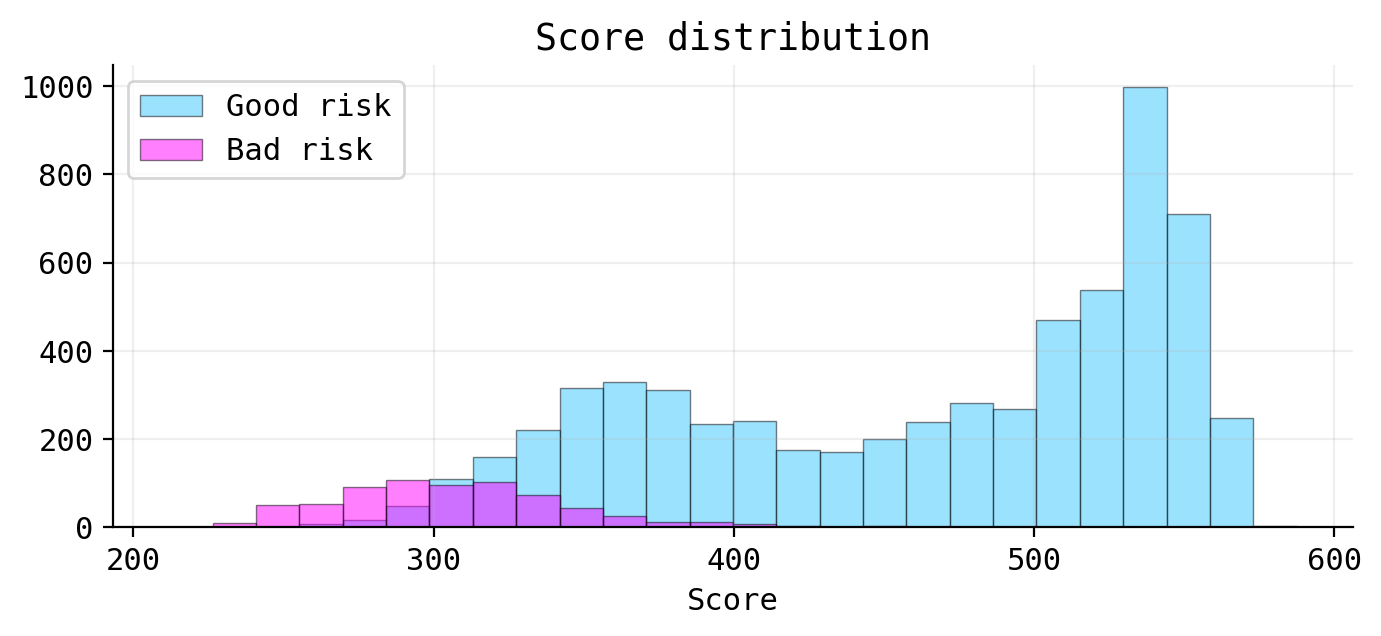

In [10]:
# Import necessary modules
from xbooster import explainer
from xbooster.constructor import XGBScorecardConstructor
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'

# Set up the scorecard constructor
scorecard_constructor = XGBScorecardConstructor(xgb_model, X.loc[ix_train], y.loc[ix_train])

scorecard_constructor.construct_scorecard()

xgb_scorecard_with_points = scorecard_constructor.create_points(
    pdo=70,
    target_points=600,
    target_odds=9,
    score_type="WOE",
)

# Plot Score Distribution
explainer.plot_score_distribution(
    scorecard_constructor=scorecard_constructor,
    fontsize=11,
    figsize=(8, 3),
    dpi=100,
)

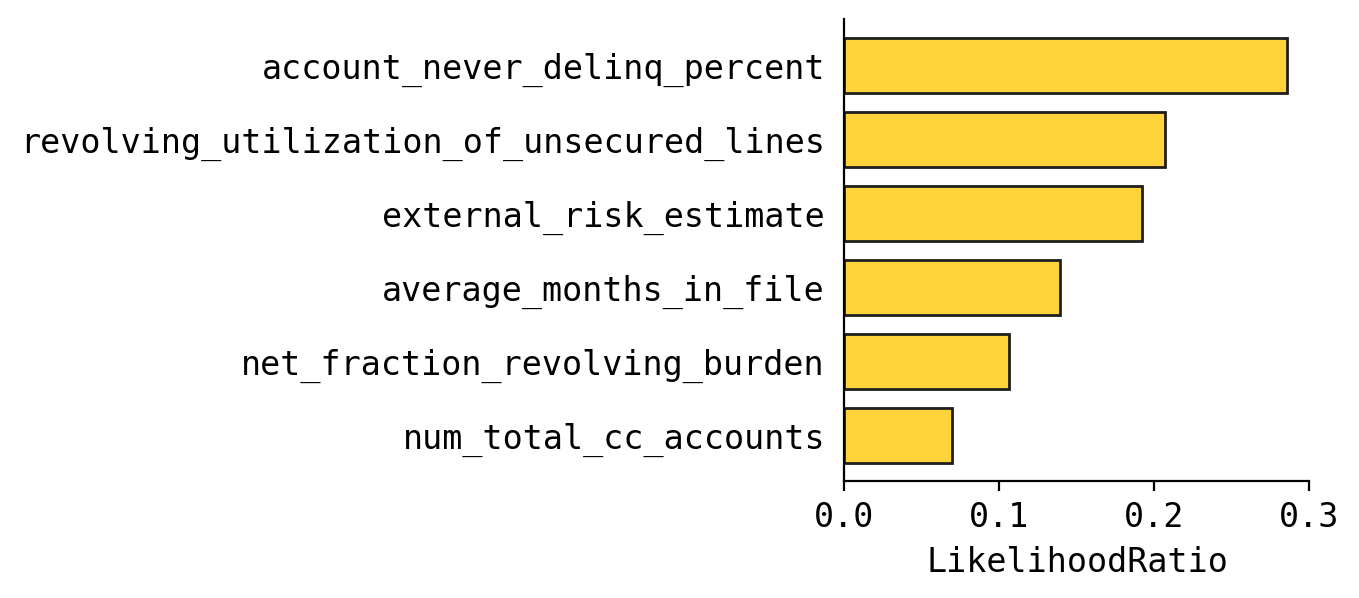

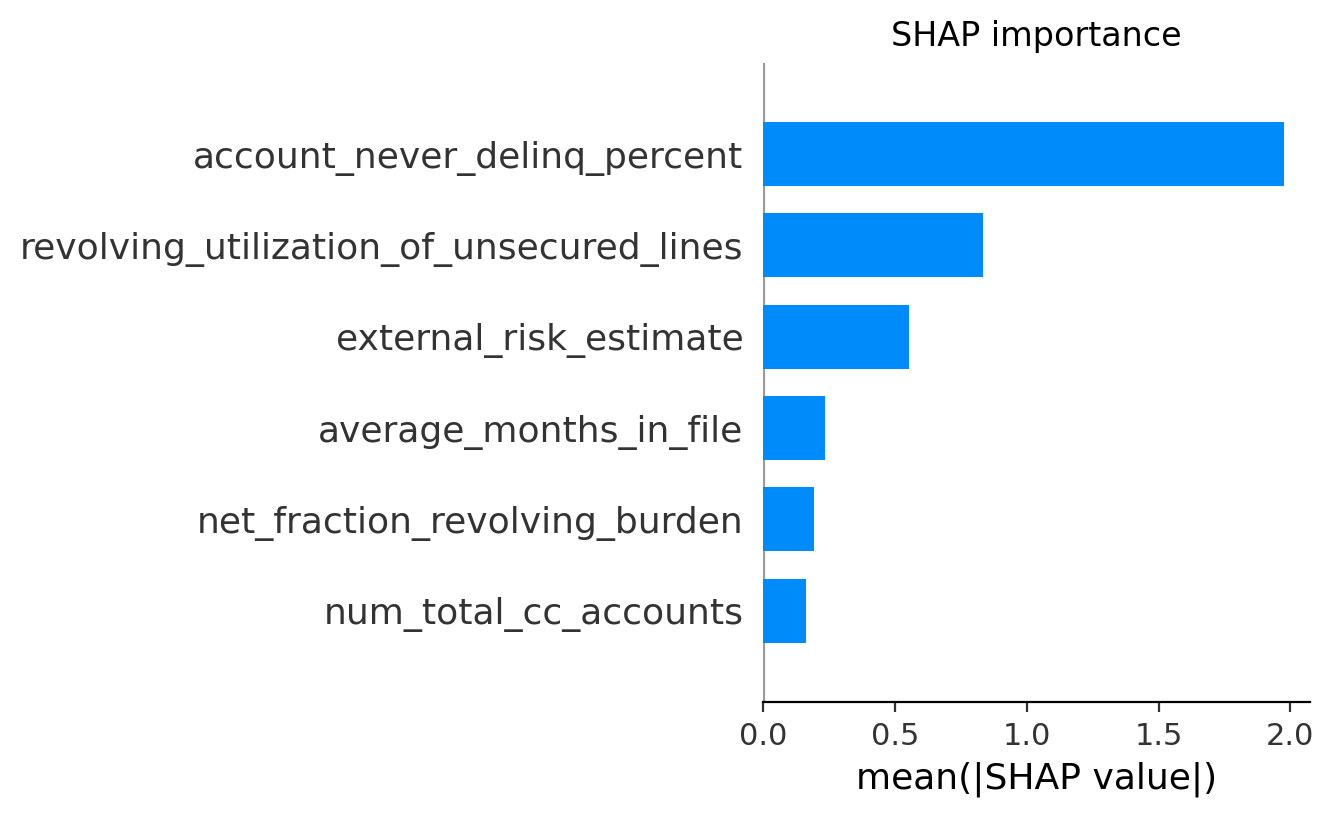

In [11]:
import shap
from matplotlib import pyplot as plt
from xbooster import explainer

shap.initjs()

# Calculate importance with LikelihoodRatio (local)
explainer.plot_importance(
    scorecard_constructor,
    metric="Likelihood",
    method="local",  # Local and Points give close SHAP values
    normalize=True,
    color="#ffd43b",
    edgecolor="#1e1e1e",
    figsize=(3, 3),
)

# Calculate SHAP values
shap_values = xgb_model.get_booster().predict(xgb.DMatrix(X.loc[ix_train]), pred_contribs=True)

fig = plt.figure(dpi=100)
shap.summary_plot(
    shap_values[:, :-1],
    feature_names=X.columns,
    plot_type="bar",
    show=False,
)
plt.title("SHAP importance")
plt.xlabel("mean(|SHAP value|)")
plt.gcf().set_size_inches(5.5, 4)
plt.show()

### <span style="font-family: Arial, sans-serif; color: navyblue; font-size: 25px;">Local explanations</span>

#### `max_depth=1` trees

In [12]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

best_params = dict(
    n_estimators=100,
    learning_rate=0.55,
    max_depth=1,
    min_child_weight=10,
    grow_policy="lossguide",
    early_stopping_rounds=5,
)

# Create an XGBoost model
xgb_model = xgb.XGBClassifier(**best_params, random_state=62)
evalset = [
    (X.loc[ix_train], y.loc[ix_train]),
    (X.loc[ix_test], y.loc[ix_test]),
]

# Fit the XGBoost model
xgb_model.fit(
    X.loc[ix_train],
    y.loc[ix_train],
    eval_set=evalset,
    verbose=False,
)

# Make predictions using the model
predictions_trn = xgb_model.predict_proba(X.loc[ix_train])[:, 1]
predictions_tst = xgb_model.predict_proba(X.loc[ix_test])[:, 1]

# Calculate the Gini score
gini_trn = roc_auc_score(y.loc[ix_train], predictions_trn) * 2 - 1  # type: ignore
gini_tst = roc_auc_score(y.loc[ix_test], predictions_tst) * 2 - 1  # type: ignore

print(f"Train Gini score: {gini_trn:.2%}\nTest Gini score: {gini_tst:.2%}")

Train Gini score: 89.84%
Test Gini score: 89.11%


In [13]:
from xbooster.constructor import XGBScorecardConstructor

# Set up the scorecard constructor
scorecard_constructor = XGBScorecardConstructor(xgb_model, X.loc[ix_train], y.loc[ix_train])

# Construct the scorecard
xgb_scorecard = scorecard_constructor.construct_scorecard()

xgb_scorecard_with_points = scorecard_constructor.create_points(
    pdo=50, target_points=600, target_odds=50
)

# Make predictions using the scorecard
credit_scores = scorecard_constructor.predict_score(X.loc[ix_test])
gini = roc_auc_score(y.loc[ix_test], -credit_scores) * 2 - 1  # type: ignore

print(f"Test Gini score: {gini:.2%}")

Test Gini score: 89.09%


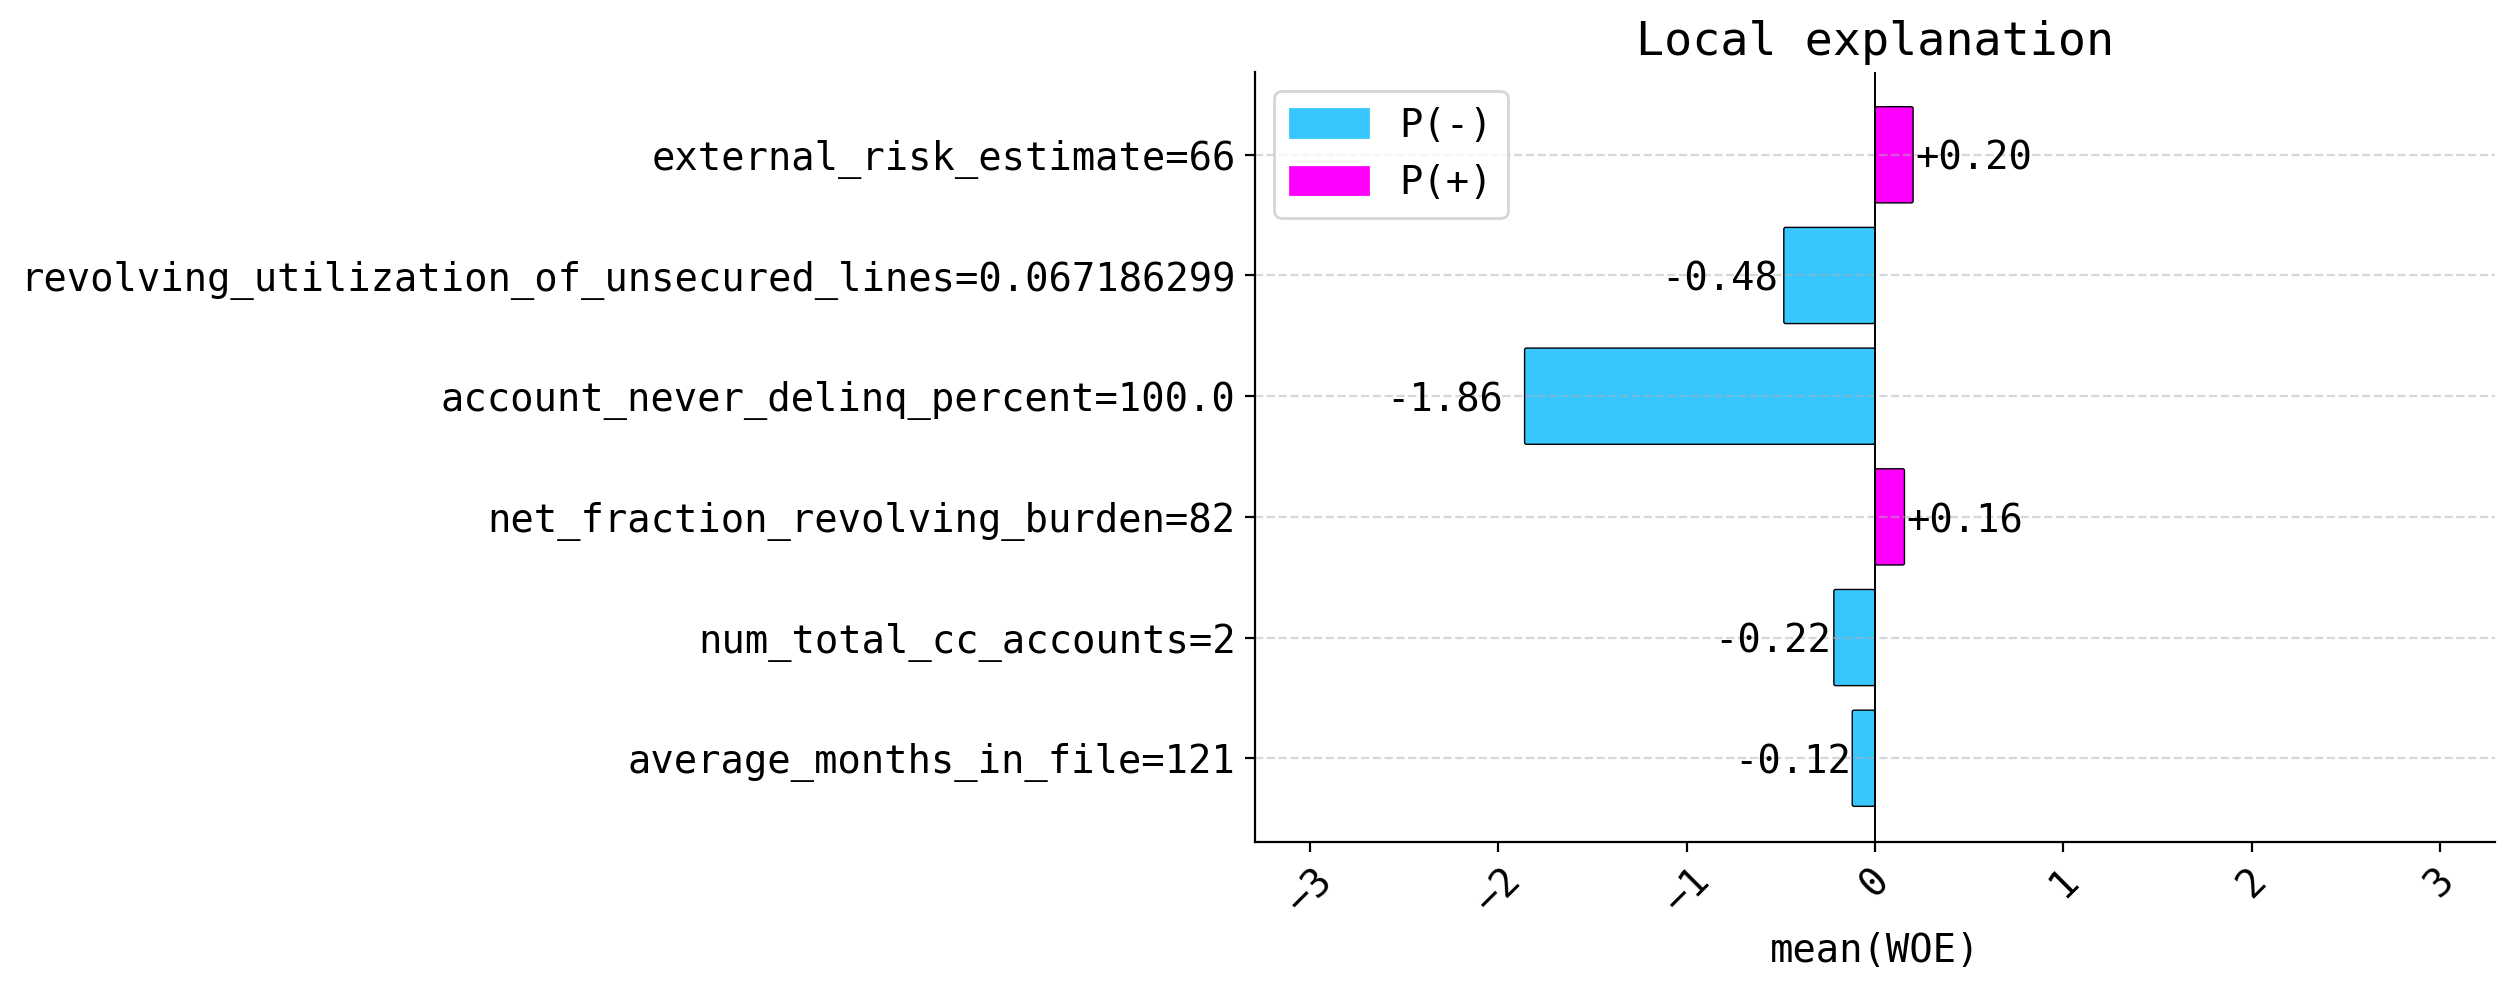

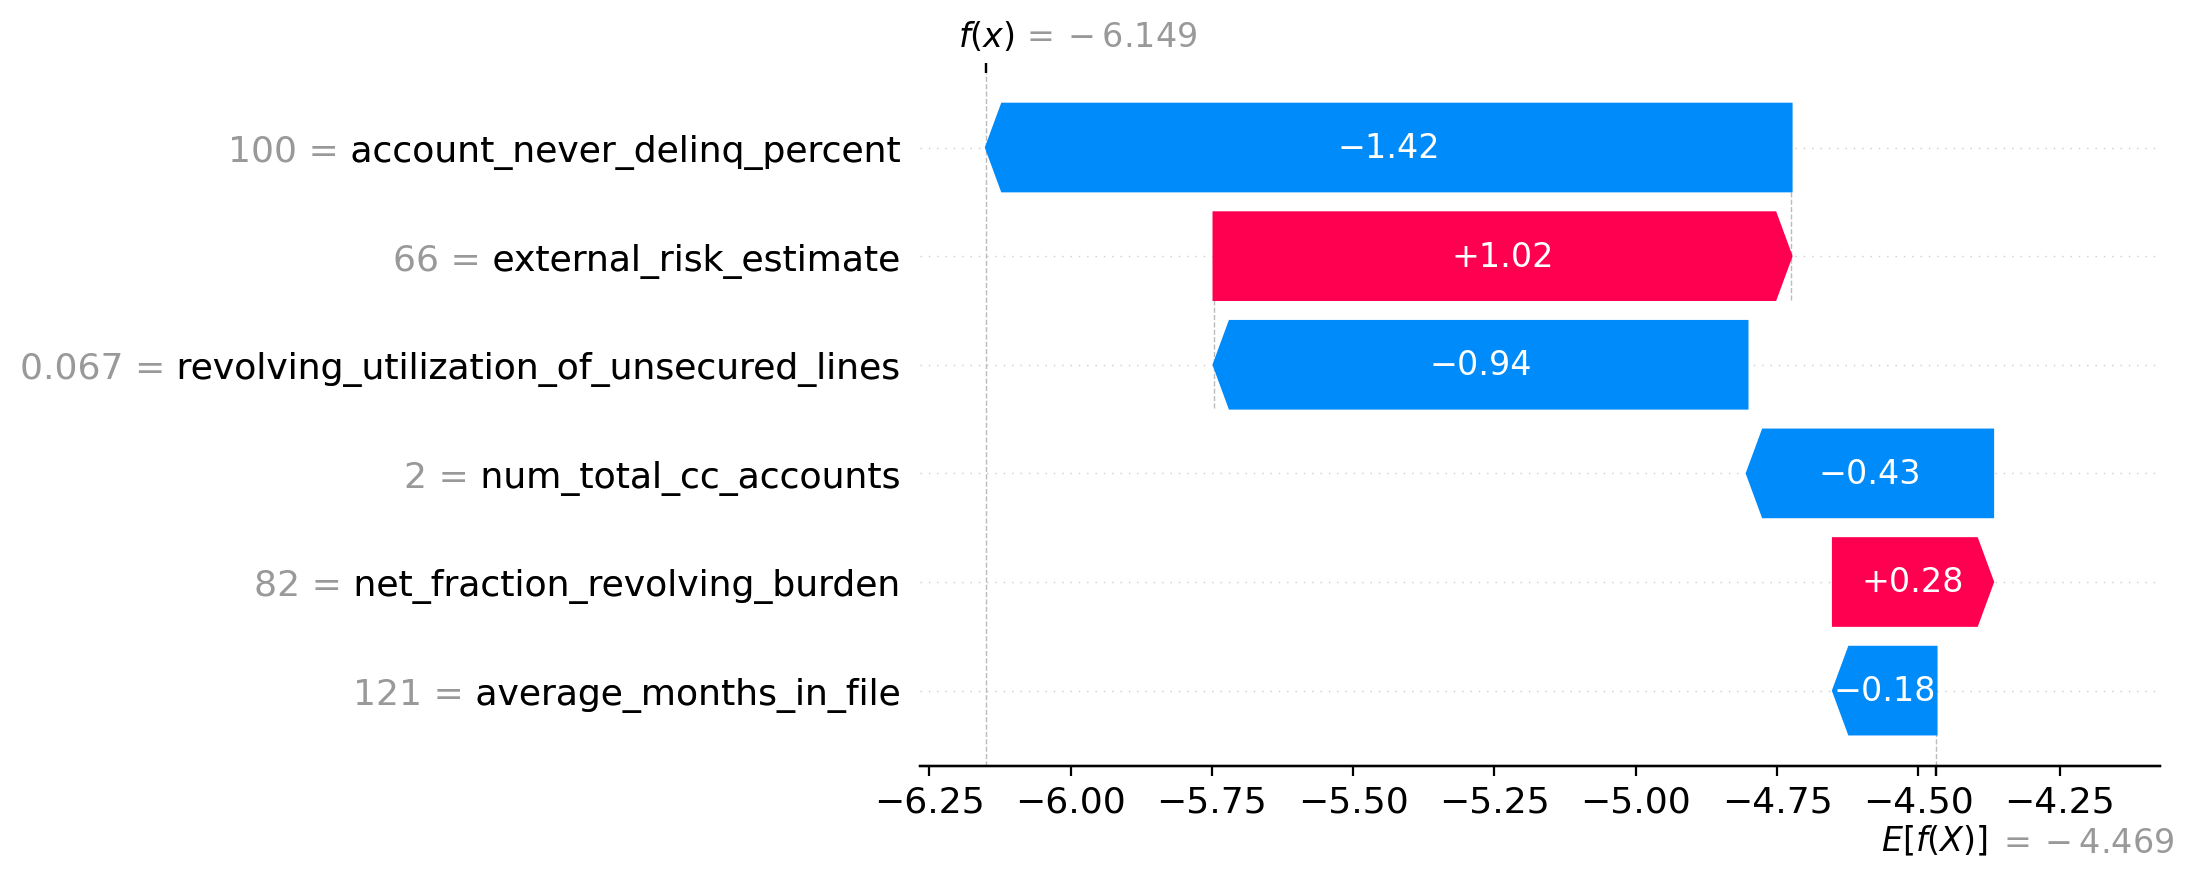

In [15]:
import shap
from matplotlib import pyplot as plt
from xbooster import explainer

shap.initjs()

%config InlineBackend.figure_format = 'retina'
sample_idx = 2
explainer.plot_local_importance(
    scorecard_constructor,
    X.loc[ix_test][sample_idx : sample_idx + 1],
    figsize=(8, 5),
    fontsize=14,
    dpi=100,
)

explainer_shap = shap.Explainer(xgb_model, X.loc[ix_test])
shap_values = explainer_shap(X.loc[ix_test])
shap.plots.waterfall(shap_values[sample_idx])

#### `max_depth>1` trees

In [16]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

best_params = dict(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=15,
    grow_policy="lossguide",
    early_stopping_rounds=5,
)

# Create an XGBoost model
xgb_model = xgb.XGBClassifier(**best_params, random_state=62)
evalset = [
    (X.loc[ix_train], y.loc[ix_train]),
    (X.loc[ix_test], y.loc[ix_test]),
]

# Fit the XGBoost model
xgb_model.fit(
    X.loc[ix_train],
    y.loc[ix_train],
    eval_set=evalset,
    verbose=False,
)

# Make predictions using the model
predictions_trn = xgb_model.predict_proba(X.loc[ix_train])[:, 1]
predictions_tst = xgb_model.predict_proba(X.loc[ix_test])[:, 1]

# Calculate the Gini score
gini_trn = roc_auc_score(y.loc[ix_train], predictions_trn) * 2 - 1  # type: ignore
gini_tst = roc_auc_score(y.loc[ix_test], predictions_tst) * 2 - 1  # type: ignore

print(f"Train Gini score: {gini_trn:.2%}\nTest Gini score: {gini_tst:.2%}")

Train Gini score: 91.20%
Test Gini score: 89.17%


In [17]:
# Import necessary modules
from xbooster import explainer
from xbooster.constructor import XGBScorecardConstructor

%config InlineBackend.figure_format = 'retina'

# Set up the scorecard constructor
scorecard_constructor = XGBScorecardConstructor(xgb_model, X.loc[ix_train], y.loc[ix_train])

scorecard_constructor.construct_scorecard()

xgb_scorecard_with_points = scorecard_constructor.create_points(
    pdo=50, target_points=600, target_odds=50
)

# Make predictions using the scorecard
credit_scores = scorecard_constructor.predict_score(X.loc[ix_test])
gini = roc_auc_score(y.loc[ix_test], -credit_scores) * 2 - 1  # type: ignore

print(f"Test Gini score: {gini:.2%}")

Test Gini score: 89.15%


explainer.py: max_depth > 1, building interactions splits.


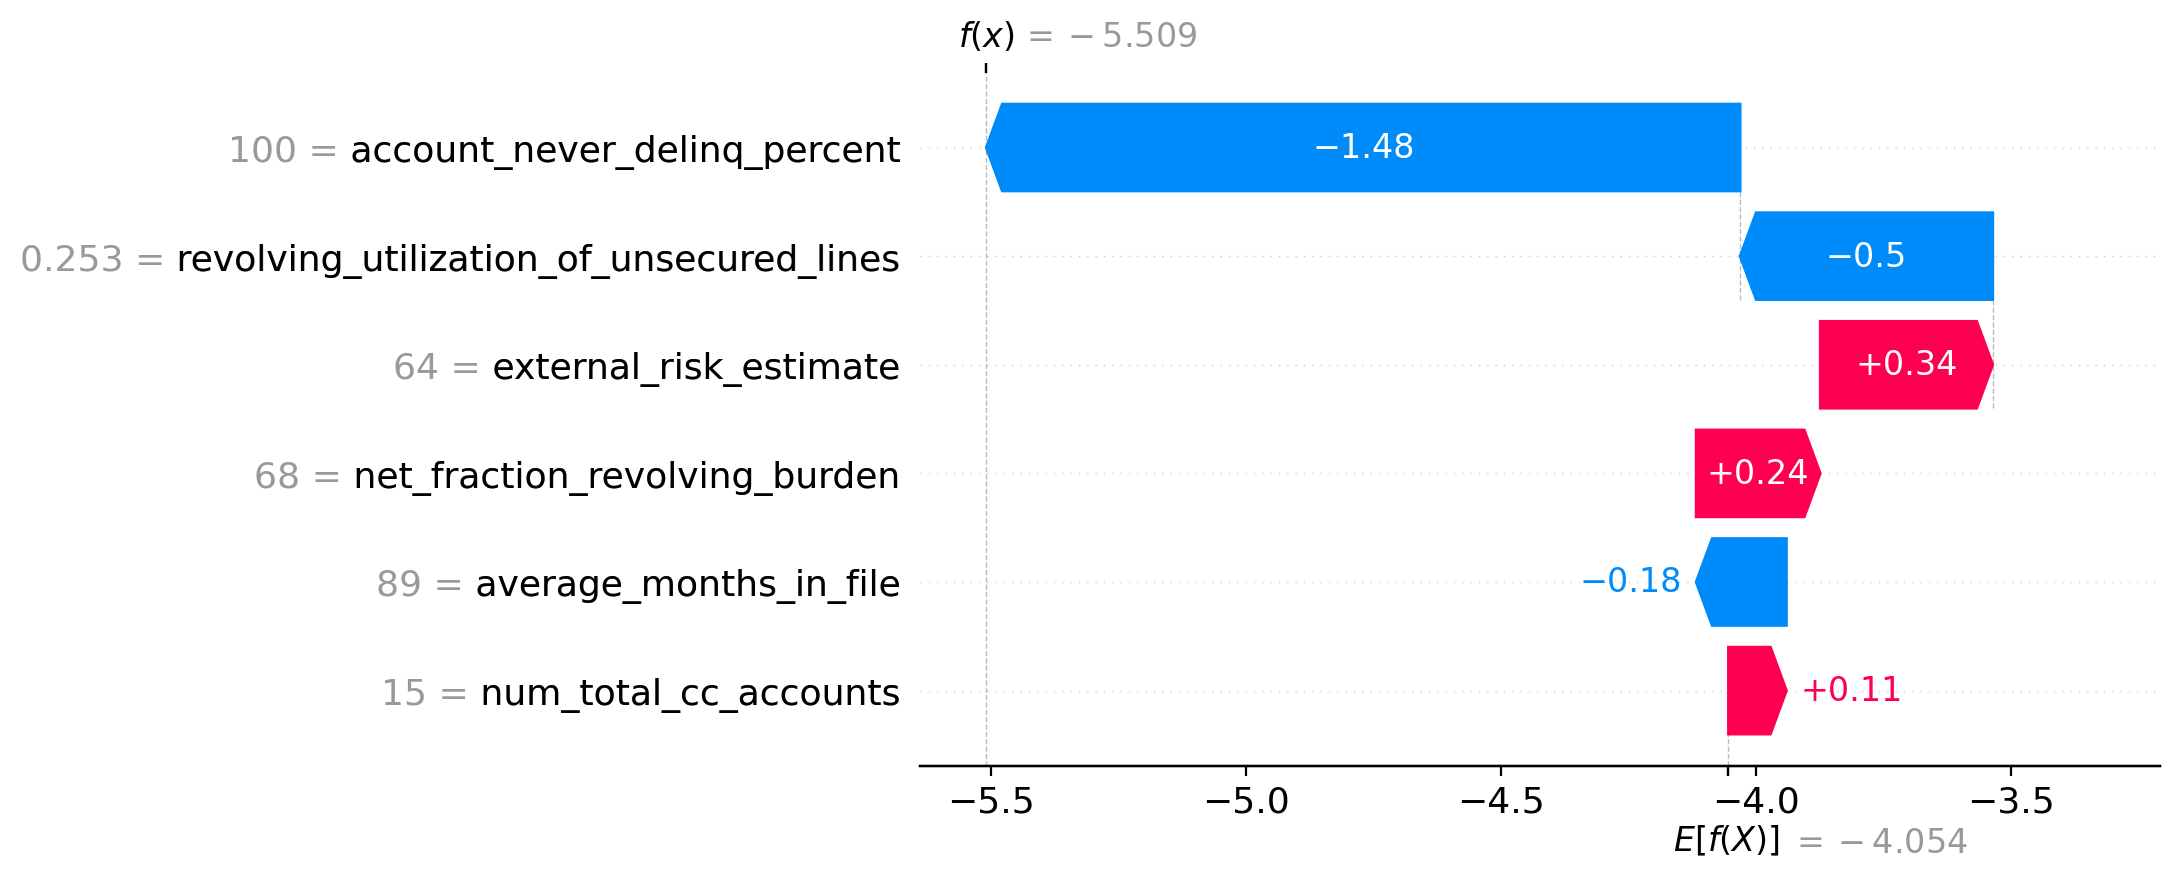

In [18]:
# For max_depth > 1
%config InlineBackend.figure_format = 'retina'

sample_idx = 20

explainer.plot_local_importance(
    scorecard_constructor,
    X.loc[ix_test][sample_idx : sample_idx + 1],
    figsize=(7.8, 5),
    fontsize=14,
    dpi=500,
)

explainer_shap = shap.Explainer(xgb_model, X.loc[ix_test])
shap_values = explainer_shap(X.loc[ix_test])
shap.plots.waterfall(shap_values[sample_idx])

### <span style="font-family: Arial, sans-serif; color: navyblue; font-size: 25px;">Serialization</span>

In [15]:
import pickle

with open("models/scorecard_constructor.pkl", "wb") as f:
    pickle.dump(scorecard_constructor, f)